
# Hotel guest assesment   

_authors: Maria Cristina Hinojosa Lee, Maarten Velghe, Daniel Borek_





## Introduction 

This  project corresponds to the final task of the course Machine Learning with Python offered by the PVW-ICES. The team will take the role of data scientists for an exclusive Hotel in the Bahamas. The goal is to screen applying Russian clients. The reason is that Russian clients represent a contrasting customer segment. On one hand, they spend a high quantity of money during their stay in the hotel. On the other hand, they also cause a high cost on damages that is not recoverable for the Hotel. 

### Problem definition 

For this work the objective was to build a model that would predict the expected value for each potential client of the hotel. After this, the best 200 applications from a list of 500 potential customers needed to be generated. The client list should represent a balance between damage and profit.  

To be able to achieve this, different algorithms had to be used. To train them, a second data set was facilitated that contained information over former guests. This data set included variables such as profit, damage (from visits that excluded the last one), age , gender, among others. 

We approached the problem in two ways. The first one consisted in predicting separately the projected revenue per clients, predicting which clients would cause damage, and then predicting the amount of damage that they would cause. This information was then used to create a measurement of the expected value for each potential customer and then to generate a client list. 

The second approach was to treat the whole problem as a model of imbalanced classification of "good" and "bad" clients. The assumption  would be that the "good" clients are the minority. This would mean that there are limited places in the client list, so the best 200 customers from the 500 applications, need to be selected. This would make the 40 % of the  applications "good" clients, while the other 60% would represent "bad" clients.
This approach would also assume that marking a "good client" as bad, would be more costly than admiting a bad customer in the good customer list.
The main analysis presented in this report refers to the first approach.

##  Exploratory Data Analysis and Preprocessing 

After importing the dataset the rows (observations) with over 70% of missing  values were removed (both for the test and the training set) 

For the preprocessing, the first step was visualizing the data. 

#Imputing

After the visualization, the missing values were handled. To accomplish this, the data set for the scores of the potential clients and the training data set of former clients were fused. This was done so that the changes made on the training data set would be the same as in the other data set. Also, the outcomes were dropped as these should not be changed or touched before the fitting of the model. 

After this, the categorical variables were chosen, and a mode imputation was carried out to replace the missing values. The categorical variables that had values other than 0 and 1, were dummified. 

```python
impute_mode = SimpleImputer(strategy="most_frequent")
for cols in [
    "client_segment",
    "credit_use_ic",
    "gluten_ic",
    "lactose_ic",
    "insurance_ic",
    "marketing_permit",
    "presidential",
    "urban_ic",
    "prev_all_in_stay",
    "shop_use",
    "company_ic",
    "dining_ic",
    "spa_ic",
    "sport_ic",
    "empl_ic",
    "sect_empl",
    "retired",
    "gold_status",
    "prev_stay",
    "divorce",
    "gender",
]:
    datafull[cols] = impute_mode.fit_transform(datafull[[cols]])
```

```python 
datafull["client_segment"] = pd.Categorical(datafull["client_segment"])
datafull["sect_empl"] = pd.Categorical(datafull["sect_empl"])
# The NaN categorie won't be necessary anymore, thanks to the mode imputing.
pd.get_dummies(datafull[["client_segment", "sect_empl"]], dummy_na=False).head()
print(datafull.shape)
datafull2 = pd.concat(
    [
        datafull,
        pd.get_dummies(
            datafull[["gender", "client_segment", "sect_empl"]], dummy_na=False
        ),
    ],
    axis=1,
)
print(datafull2.shape)
print(datafull2.head(1000))

```






The next step was to drop the original features and one dummy category for the categorical variables. In this point the feature “profit per night” (the result of the division of the profit amount and the nights booked) was created. 

Then the features that had more than 25% of missing values were found. In here, there was a choice: they could be dropped or another way to handle them could be selected. As they represented the scores of the clients, it was decided that instead dropping them, a mean imputation (as they were quantitative data), was chosen. Mean imputations were also chosen for the rest of the missing data. 
```python
impute_quant = SimpleImputer (strategy='mean')
for cols in ['score1_pos', 'score1_neg', 'score2_pos', 'score2_neg', 'score3_pos',
       'score3_neg', 'score4_pos', 'score4_neg', 'score5_pos', 'score5_neg']:  # Missing data, Scores are quantitative
      datafull2[cols] = impute_quant.fit_transform(datafull2[[cols]])
```


As the last steps of the preprocessing, the data was rescaled and the score and data_train sets were again separated. 
```python
scaler = StandardScaler()
datafull3 = pd.DataFrame(scaler.fit_transform(datafull2))
datafull3.columns = datafull2.columns

data_train = pd.concat([data_train[['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount']],datafull3[0:5000]], axis=1)
print(data_train.shape)
score = datafull3[5000:5500] #The score dataset will be the last 500 observations
score.shape
```

## Models


###  Profit Model 

After the preprocessing, the data was split in train and test. The test size was decided to be 20%, so that more data was available for the training. 
```python
X_train, X_test, y_train, y_test = train_test_split(data_train.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount'],1),
                                                    data_train['outcome_profit'], test_size=0.2, random_state=48)
```
For the Profit Model, the algorithms selected were Gradient Booster and GAM. Unfortunately the GAM model did not converge, the informtion of it can be found in the notebook. In the case of Gradient booster, 500 random hyperparameter combinations were tried, each time using 5 Cross Validation folds, totalling 2500 fits. It took around 50 minutes to run.
Then in the next section the model is pickled, to not let all that time that the model took to run, to get wasted. It is a way to persist it.
```python
score.to_pickle(data_output_path / "score_v3.pkl")
data_train.to_pickle(data_output_path / "data_train_v3.pkl")
joblib.dump(gbm_random, 'random_search_gbm.pkl')
```
After this, the output was examined and the best hyperparameter combination is inspected.
```python 
pd.DataFrame(gbm_random.cv_results_).loc[pd.DataFrame(gbm_random.cv_results_)['mean_test_score'].idxmax()]
```

Finally, the best parameters are used to fit the model. And in the last point, the potential clients are scored with the model and this is saved. R2 for the X_train was 0.975 and for the X_test was 0.829 
```python 
params = gbm_random.best_params_
gbm_profit = GradientBoostingRegressor(**params)
gbm_profit.fit(X_train, y_train)
print('R2: %.3f' % gbm_profit.score(X_train, np.array(y_train).reshape(-1,1)))
print('R2: %.3f' % gbm_profit.score(X_test, np.array(y_test).reshape(-1,1)))
```
The next step was to try a way to "whitebox" the model. For it, the variables that mattered were identified using Variable importances based on impurity reduction. After this, Permutation importance was also carried. Both Feature importance and Permutation importance identified the same strongly predictive features for the model for Profit: Profit per night, Mean taxable income of neighborhood, Presidential suit previous use, and the amount spent in shop, but in different order.

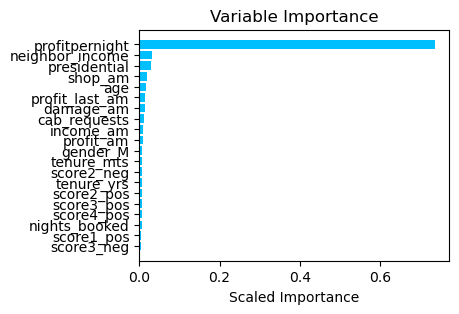
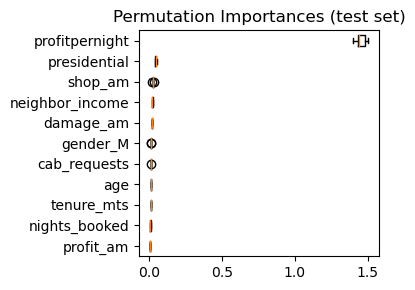


 

###  Prediction of Damage (binary) 

There was used different  models to predict if the client will do some damage. First we did a  modelling on a whole dataset  without removing any features. The first one was Gradient Boosting for classification. Train accuracy was quite low : 0.773, test accuracy: 0.739.

So we wanted to try another model - Histogram Gradiënt Boosting Classifier. It  has similarly low train accuracy: 0.765 and test accuracy: 0.726. It is quite low.

So maybe is good to removed some features. Using  features importance regression we created a list of features (the criterium was p_value < 0.05 or mutual information > 0.005). We ended with the the list of 27 variables. On the start we used very simple model, logistic regression. And it improved our accuracy. Train accuracy was 0.76. Test accuracy was 0.75. We looked also to other metrics.



###  Prediction of Damage (amount) 

# Analysis approaches

- I would like to try set of traditional machine learning algorithms
- SMOTE for Imbalanced Classification with Python (this is to much but this is an learning experience)
- and XDBooost



## Results  

 

Speak over the customer list, and over how it was selected. 

### Improvements/modifications 
 

### Concluding remarks 


### Reproducibility

All work was done in  the collaborative manner using Github and Google collab.

